<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_TPU_MNIST_Tiny_SGD_run2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  44031      0 --:--:-- --:--:-- --:--:-- 44031
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.8MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                             

In [ ]:
!pip install fastai2 --upgrade > /dev/null

In [ ]:
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [ ]:
!pip install -e ".[dev]"

Obtaining file:///content/drive/My%20Drive/fastai_xla_extensions
     |████████████████████████████████| 51kB 1.9MB/s 
  Running setup.py develop for fastai-xla-extensions


In [ ]:
%cd /content

/content


### Import Libraries

In [ ]:
from fastai2.vision.all import *

In [ ]:
import torch_xla.core.xla_model as xm

In [ ]:
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [ ]:
from fastai_xla_extensions.core import *

In [ ]:
%cd /content

/content


### Setup data

In [ ]:
path = untar_data(URLs.MNIST_TINY)

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7644.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7644.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying Resize gives
      (PILImageBW mode=L size=28x28, TensorCa

### Setup TPU

In [ ]:
tpu = xm.xla_device()

### Setup DataLoaders

In [ ]:
dls = datablock.dataloaders(path, device=tpu)

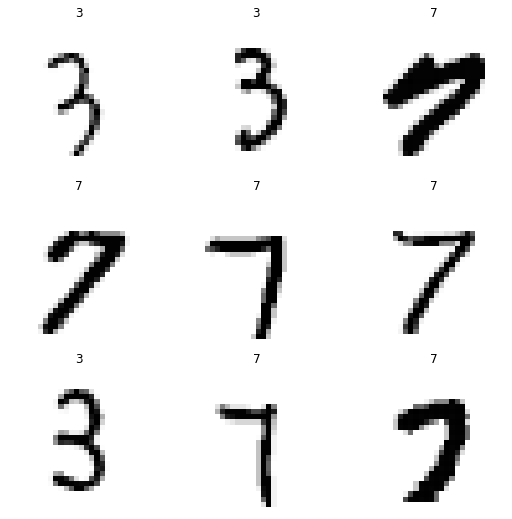

In [ ]:
dls.show_batch()

### Create Learner

In [ ]:
opt_func = XLAOptFuncWrapper(SGD)

In [ ]:
learner = cnn_learner(dls,resnet18,metrics=accuracy,opt_func=opt_func)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [ ]:
learner.fit(1,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.230996,0.648106,0.605150,00:13


In [ ]:
learner.fit(100,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.065354,0.693843,0.580830,00:04
1,1.059621,0.763412,0.576538,00:02
2,0.991787,0.752729,0.595136,00:02
3,0.972316,0.704359,0.626609,00:02
4,0.937276,0.661739,0.663805,00:02
5,0.922108,0.605018,0.695279,00:02
6,0.902674,0.557938,0.718169,00:01
7,0.866847,0.540179,0.723891,00:02
8,0.834286,0.518274,0.743920,00:01
9,0.807816,0.492913,0.761087,00:01


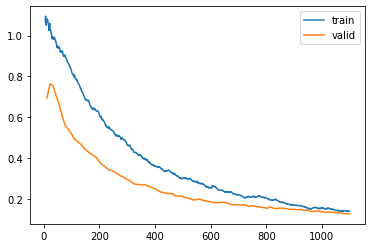

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.save('100epoch-tpu')
# not saving?

In [ ]:
!mkdir -p /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18
!cp /content/models/100epoch-tpu.pth /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [ ]:
learner.fit(1,lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.146425,0.114161,0.967096,00:06


In [ ]:
learner.fit(100,lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.112040,0.109571,0.965665,00:04
1,0.118091,0.101155,0.969957,00:02
2,0.104056,0.101272,0.968526,00:02
3,0.100357,0.095231,0.969957,00:02
4,0.087324,0.095465,0.969957,00:02
5,0.078421,0.096893,0.968526,00:02
6,0.071802,0.092348,0.972818,00:02
7,0.067457,0.091305,0.969957,00:02
8,0.063817,0.089002,0.972818,00:02
9,0.059547,0.085312,0.971388,00:02


In [ ]:
learner.save('200epoch-tpu')

In [ ]:
!cp /content/models/200epoch-tpu.pth /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.fit(1,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.014966,0.411798,0.872675,00:07


In [ ]:
learner.load('200epoch-tpu')

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.fit(1,3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.035181,0.087136,0.979971,00:04


In [ ]:
learner.fit(100,3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.031167,0.104968,0.972818,00:02
1,0.033027,0.055014,0.987124,00:02
2,0.028160,0.050218,0.985694,00:02
3,0.023171,0.047010,0.984263,00:02
4,0.021405,0.044869,0.984263,00:02
5,0.022267,0.046296,0.979971,00:02
6,0.022523,0.055260,0.988555,00:02
7,0.020898,0.067925,0.987124,00:02
8,0.018676,0.069919,0.984263,00:02
9,0.017434,0.070361,0.987124,00:02


In [ ]:
learner.save('300epoch-tpu')

In [ ]:
learner.load('200epoch-tpu')

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.fit(55, 3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.008216,0.082661,0.978541,00:02
1,0.015314,0.078784,0.979971,00:02
2,0.030065,0.049561,0.984263,00:02
3,0.030891,0.066259,0.982833,00:02
4,0.027684,0.061514,0.982833,00:02
5,0.024889,0.058910,0.981402,00:02
6,0.025746,0.051013,0.985694,00:02
7,0.021031,0.046796,0.985694,00:02
8,0.019237,0.049042,0.977110,00:02
9,0.018199,0.055279,0.987124,00:02


In [ ]:
learner.save('355epoch-tpu')

In [ ]:
learner.fit(5,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.005608,0.066075,0.985694,00:02
1,0.005501,0.063906,0.985694,00:02
2,0.004303,0.065932,0.987124,00:02
3,0.004243,0.059847,0.987124,00:02
4,0.006342,0.059860,0.988555,00:02


In [ ]:
learner.save('360epoch-tpu')

In [ ]:
learner.fit(10,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.002109,0.058249,0.985694,00:02
1,0.002757,0.061543,0.985694,00:02
2,0.003022,0.068762,0.985694,00:02
3,0.003219,0.052798,0.985694,00:02
4,0.002706,0.054890,0.984263,00:02
5,0.002749,0.051467,0.985694,00:02
6,0.002318,0.052882,0.985694,00:02
7,0.003774,0.052609,0.987124,00:02
8,0.003264,0.052151,0.987124,00:02
9,0.002872,0.052232,0.985694,00:02


In [ ]:
learner.save('370epoch-tpu')

In [ ]:
!cp /content/models/300epoch-tpu.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.
!cp /content/models/355epoch-tpu.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.
!cp /content/models/360epoch-tpu.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.
!cp /content/models/370epoch-tpu.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

In [ ]:
opt = learner.opt

In [ ]:
len(opt.param_lists)

3

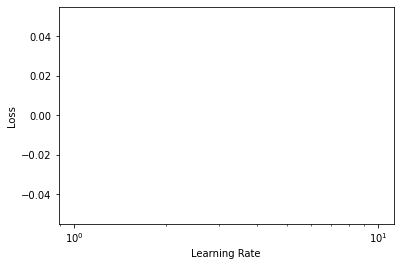

In [ ]:
learner.lr_find()